Image CRS: EPSG:32643
Image bounds: BoundingBox(left=540378.3252300001, bottom=3489958.00821, right=541176.59883, top=3490790.66421)

Processing Utility.shp...
Original SHP CRS: EPSG:3857
Reprojecting to EPSG:32643...
Error occurred: 0


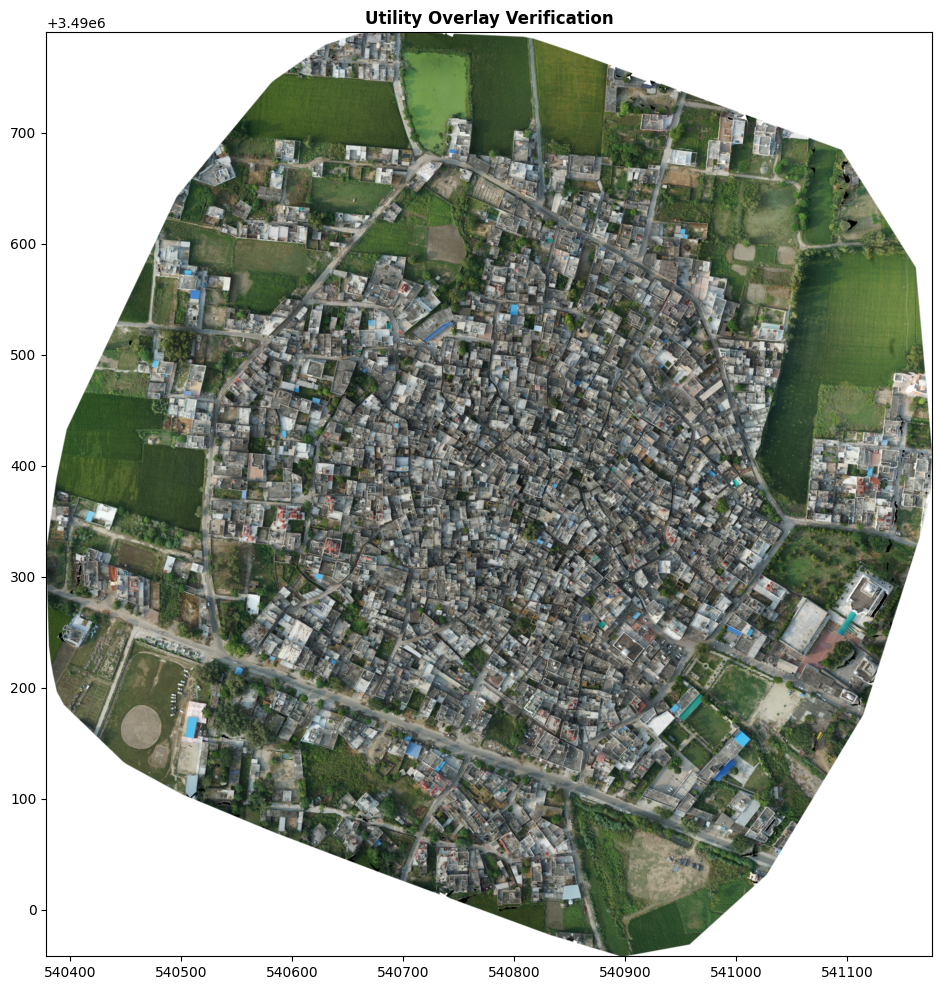

In [1]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.plot import show
import numpy as np

# 1. Paths configuration
# Update these if your specific file names change
IMG_PATH = "../data/images/28996_NADALA_ORTHO.tif"
SHP_UTILITY_POINT = "../data/shp/Utility.shp"
SHP_UTILITY_POLY = "../data/shp/Utility_Poly_.shp" 
SHP_WATERBODY = "../data/shp/Waterbody_Point.shp"

def visualize_utility_overlay(img_path, shp_paths):
    # Check if image exists
    if not os.path.exists(img_path):
        # Fallback search
        import glob
        tifs = glob.glob("../data/images/*.tif")
        if tifs:
            img_path = tifs[0]
            print(f"Using found image: {img_path}")
        else:
            print(f"Image not found at {img_path}")
            return

    # Open Orthophoto (Memory Efficiently)
    try:
        with rasterio.open(img_path) as src:
            print(f"Image CRS: {src.crs}")
            print(f"Image bounds: {src.bounds}")
            
            # Read a downsampled overview for visualization (e.g., 1/16th scale)
            # This prevents crashing on large TIFFs while keeping coordinates correct
            out_shape = (
                src.count,
                int(src.height / 16),
                int(src.width / 16)
            )
            img = src.read(out_shape=out_shape, resampling=rasterio.enums.Resampling.bilinear)
            
            # Update transform for the downsampled image so coordinates align
            transform = src.transform * src.transform.scale(
                (src.width / out_shape[-1]),
                (src.height / out_shape[-2])
            )
            
            img_crs = src.crs

            # Prepare plotting
            fig, ax = plt.subplots(figsize=(12, 12))
            
            # Display RGB Image
            # show() takes the transform to place it correctly in coordinates
            # Normalize for display if needed (simple min-max)
            img_display = img / 255.0 if img.max() > 1 else img
            show(img_display, transform=transform, ax=ax, title="Utility Overlay Verification")
            
            # Colors for different shapefiles
            colors = ['red', 'blue', 'cyan']
            
            # Load and Overlay Shapefiles
            for i, shp_path in enumerate(shp_paths):
                if os.path.exists(shp_path):
                    print(f"\nProcessing {os.path.basename(shp_path)}...")
                    gdf = gpd.read_file(shp_path)
                    print(f"Original SHP CRS: {gdf.crs}")
                    
                    # Reproject if needed
                    if gdf.crs != img_crs:
                        print(f"Reprojecting to {img_crs}...")
                        gdf = gdf.to_crs(img_crs)
                    
                    # Filter data within image bounds to speed up plotting
                    minx, miny, maxx, maxy = src.bounds
                    gdf = gdf.cx[minx:maxx, miny:maxy]
                    
                    if not gdf.empty:
                        # Plot based on type
                        if gdf.geom_type[0] == 'Point':
                             gdf.plot(ax=ax, color=colors[i % len(colors)], markersize=20, 
                               label=os.path.basename(shp_path), alpha=1.0, edgecolor='white')
                        else:
                             gdf.plot(ax=ax, color=colors[i % len(colors)], 
                               label=os.path.basename(shp_path), alpha=0.5, edgecolor='black')
                        print("Overlay added.")
                    else:
                        print("No features found within image bounds.")
                else:
                    print(f"File not found: {shp_path}")
            
            plt.legend()
            plt.show()
            
    except Exception as e:
        print(f"Error occurred: {e}")

# Run Visualization
visualize_utility_overlay(IMG_PATH, [SHP_UTILITY_POINT, SHP_UTILITY_POLY, SHP_WATERBODY])

In [2]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import Point, LineString, Polygon
from tqdm import tqdm

# 1. Configuration
# Update paths if needed
IMG_PATH = "../data/images/28996_NADALA_ORTHO.tif"
SHP_PATHS = [
    "../data/shp/Utility.shp",      # Points
    "../data/shp/Utility_Poly_.shp" # Polygons
]
OUTPUT_MASK_PATH = "../data/masks/utility_mask_full.tif"

# Create output dir
os.makedirs(os.path.dirname(OUTPUT_MASK_PATH), exist_ok=True)

def generate_utility_mask(img_path, shp_paths, output_path):
    print(f"Generating mask for: {img_path}")
    
    # 1. Read Image Metadata
    with rasterio.open(img_path) as src:
        height, width = src.height, src.width
        transform = src.transform
        crs = src.crs
        res = src.res[0] # Pixel resolution (meters)
        out_profile = src.profile.copy()
        
    print(f"Dimensions: {width}x{height}")
    print(f"Resolution: {res} m/pixel")
    
    # 2. Collect all geometries
    all_geometries = []
    
    for shp_path in shp_paths:
        if not os.path.exists(shp_path):
            print(f"Skipping missing file: {shp_path}")
            continue
            
        print(f"Loading {os.path.basename(shp_path)}...")
        gdf = gpd.read_file(shp_path)
        
        # Reproject if necessary
        if gdf.crs != crs:
            print(f"Reprojecting from {gdf.crs} to {crs}...")
            gdf = gdf.to_crs(crs)
            
        # Add to list with buffering for visibility
        # Buffer Config:
        # Points -> Circles of 1 meter radius (approx 10-20 pixels depending on res)
        # We use a fixed physical size (meters) so it's consistent.
        buffer_radius_meters = 2.0 
        
        count = 0
        for geom in tqdm(gdf.geometry, desc=f"Processing {os.path.basename(shp_path)}"):
            if geom is None or geom.is_empty:
                continue
                
            if isinstance(geom, Point):
                # Buffer points to circles
                all_geometries.append(geom.buffer(buffer_radius_meters))
            elif isinstance(geom, LineString):
                # Buffer lines to have thickness
                all_geometries.append(geom.buffer(buffer_radius_meters / 2))
            else:
                # Polygons added as is
                all_geometries.append(geom)
            count += 1
            
        print(f"Added {count} geometries.")

    if not all_geometries:
        print("No valid geometries found to rasterize.")
        return

    print(f"Rasterizing {len(all_geometries)} geometries...")
    
    # 3. Rasterize
    # Note: Creating a (30k x 30k) uint8 array requires ~900MB RAM.
    # This is safe for standard systems.
    
    # Prepare iterable (geom, value)
    # Value 1 = Object, 0 = Background
    shapes = ((g, 1) for g in all_geometries)
    
    mask = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    
    # 4. Save
    # Use LZW compression to make the file small (masks compress very well)
    out_profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=0)
    
    with rasterio.open(output_path, 'w', **out_profile) as dst:
        dst.write(mask, 1)
        
    print(f"Saved binary utility mask to: {output_path}")

# Run
generate_utility_mask(IMG_PATH, SHP_PATHS, OUTPUT_MASK_PATH)

Generating mask for: ../data/images/28996_NADALA_ORTHO.tif
Dimensions: 26259x27390
Resolution: 0.030400000000000003 m/pixel
Loading Utility.shp...
Reprojecting from EPSG:3857 to EPSG:32643...


Processing Utility.shp:   0%|          | 0/1227 [00:00<?, ?it/s]

Processing Utility.shp: 100%|██████████| 1227/1227 [00:00<00:00, 54544.22it/s]


Added 1227 geometries.
Loading Utility_Poly_.shp...
Reprojecting from EPSG:3857 to EPSG:32643...


Processing Utility_Poly_.shp: 100%|██████████| 1193/1193 [00:00<00:00, 302417.79it/s]

Added 1193 geometries.
Rasterizing 2420 geometries...


Saved binary utility mask to: ../data/masks/utility_mask_full.tif


In [3]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from shapely.geometry import Point, LineString, Polygon
from tqdm import tqdm

# 1. Configuration
# Update paths if needed
IMG_PATH = "../data/images/28996_NADALA_ORTHO.tif"
SHP_PATHS = [
    "../data/shp/Utility.shp",      # Points
    "../data/shp/Utility_Poly_.shp" # Polygons
]
OUTPUT_MASK_PATH = "../data/masks/utility_mask_full.tif"

# Create output dir
os.makedirs(os.path.dirname(OUTPUT_MASK_PATH), exist_ok=True)

def generate_utility_mask(img_path, shp_paths, output_path):
    print(f"Generating mask for: {img_path}")
    
    # 1. Read Image Metadata
    try:
        with rasterio.open(img_path) as src:
            height, width = src.height, src.width
            transform = src.transform
            crs = src.crs
            res = src.res[0] # Pixel resolution (meters)
            out_profile = src.profile.copy()
            
        print(f"Dimensions: {width}x{height}")
        print(f"Resolution: {res:.4f} m/pixel")
    except FileNotFoundError:
        print(f"Error: Image not found at {img_path}")
        return
    
    # 2. Collect all geometries
    all_geometries = []
    
    # Dynamic buffer size: ensure points are at least 6 pixels in diameter (radius 3px)
    # This prevents them from vanishing if we resize later.
    min_pixel_radius = 3.0
    buffer_radius_meters = res * min_pixel_radius
    print(f"Buffering points/lines by {buffer_radius_meters:.2f} meters ({min_pixel_radius} pixels)")
    
    for shp_path in shp_paths:
        if not os.path.exists(shp_path):
            print(f"Skipping missing file: {shp_path}")
            continue
            
        print(f"Loading {os.path.basename(shp_path)}...")
        gdf = gpd.read_file(shp_path)
        
        # Reproject if necessary
        if gdf.crs != crs:
            print(f"Reprojecting from {gdf.crs} to {crs}...")
            gdf = gdf.to_crs(crs)
            
        count = 0
        for geom in tqdm(gdf.geometry, desc=f"Processing {os.path.basename(shp_path)}"):
            if geom is None or geom.is_empty:
                continue
                
            if isinstance(geom, Point):
                # Buffer points to circles
                all_geometries.append(geom.buffer(buffer_radius_meters))
            elif isinstance(geom, LineString):
                # Buffer lines to have thickness
                all_geometries.append(geom.buffer(buffer_radius_meters / 2))
            else:
                # Polygons added as is. 
                # Note: If polygon is invalid/self-intersecting, buffer(0) fixes it.
                if not geom.is_valid:
                    geom = geom.buffer(0)
                all_geometries.append(geom)
            count += 1
            
        print(f"Added {count} geometries.")

    if not all_geometries:
        print("No valid geometries found to rasterize.")
        return

    print(f"Rasterizing {len(all_geometries)} geometries...")
    
    # 3. Rasterize
    # Prepare iterable (geom, value)
    # Value 1 = Object, 0 = Background
    shapes = ((g, 1) for g in all_geometries)
    
    mask = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='uint8'
    )
    
    # 4. Save
    # Use LZW compression to make the file small (masks compress very well)
    out_profile.update(dtype=rasterio.uint8, count=1, compress='lzw', nodata=0)
    
    with rasterio.open(output_path, 'w', **out_profile) as dst:
        dst.write(mask, 1)
        
    print(f"Saved binary utility mask to: {output_path}")

# Run
generate_utility_mask(IMG_PATH, SHP_PATHS, OUTPUT_MASK_PATH)

Generating mask for: ../data/images/28996_NADALA_ORTHO.tif
Dimensions: 26259x27390
Resolution: 0.0304 m/pixel
Buffering points/lines by 0.09 meters (3.0 pixels)
Loading Utility.shp...
Reprojecting from EPSG:3857 to EPSG:32643...


Processing Utility.shp: 100%|██████████| 1227/1227 [00:00<00:00, 55826.99it/s]

Added 1227 geometries.
Loading Utility_Poly_.shp...
Reprojecting from EPSG:3857 to EPSG:32643...


Processing Utility_Poly_.shp: 100%|██████████| 1193/1193 [00:00<00:00, 114563.84it/s]

Added 1193 geometries.
Rasterizing 2420 geometries...


Saved binary utility mask to: ../data/masks/utility_mask_full.tif


Generating tiles...


Processing Grid: 100%|██████████| 702/702 [00:36<00:00, 19.17it/s]



Completed! Saved 54 tiles matching utilities.

Visualizing 5 random samples...


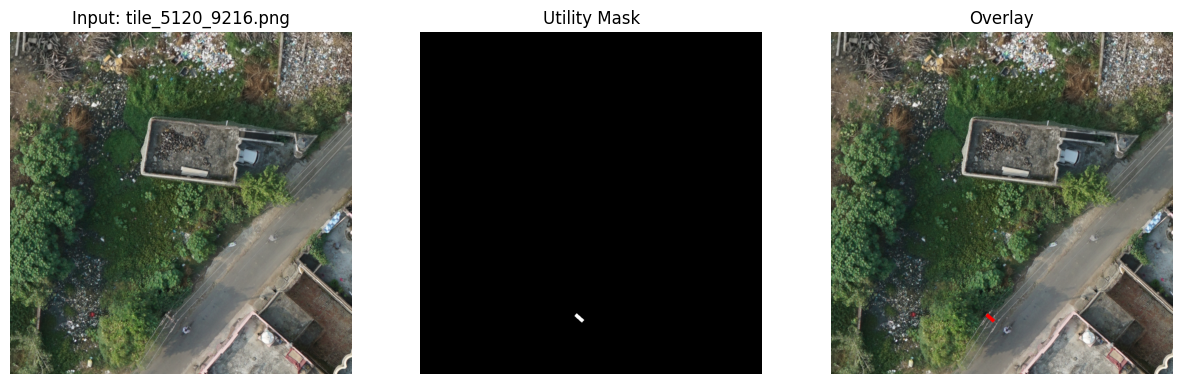

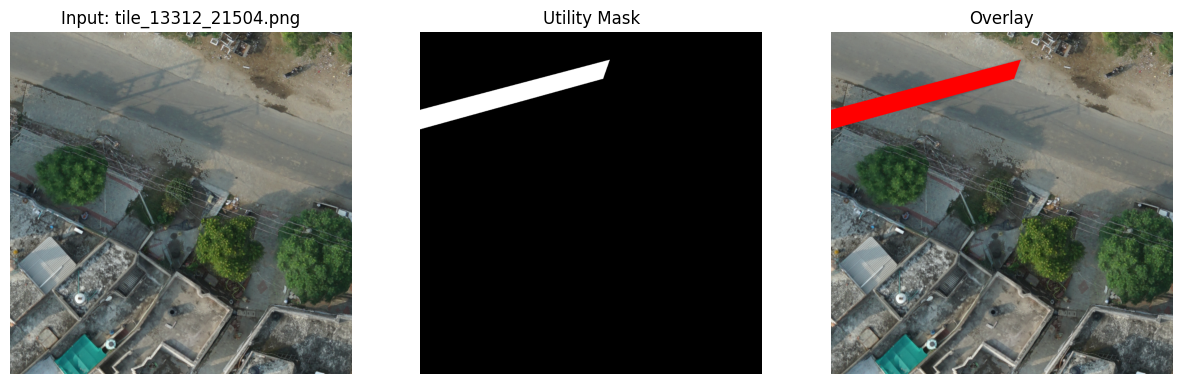

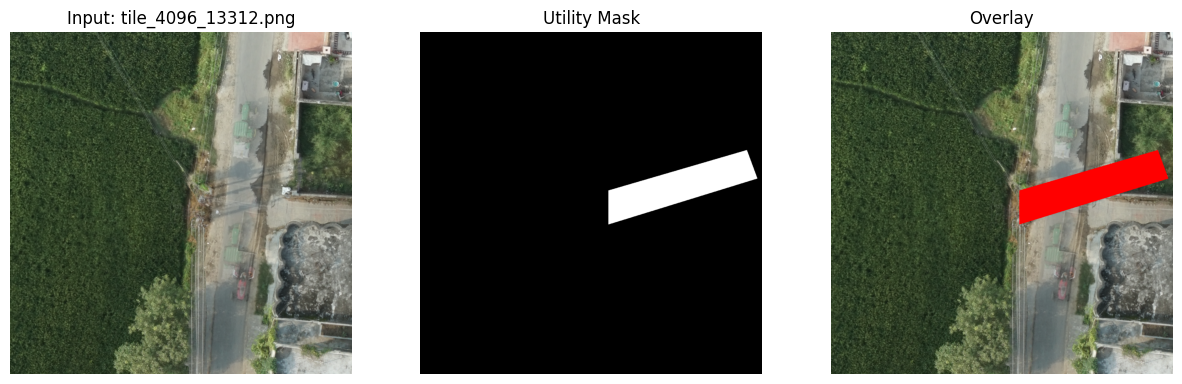

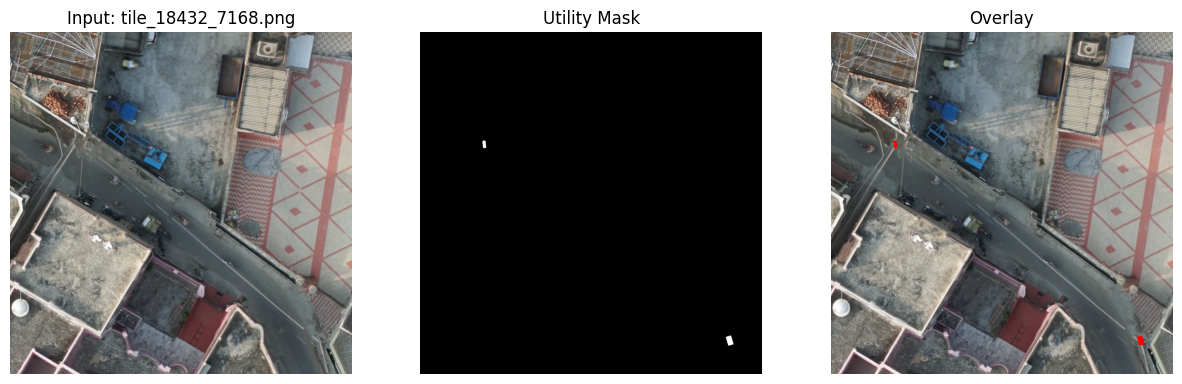

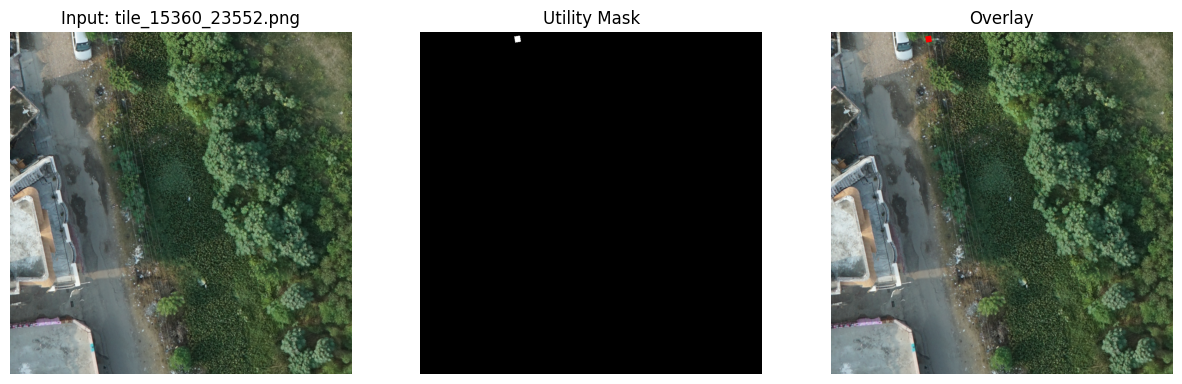

In [8]:
import os
import rasterio
import numpy as np
import glob
import random
import matplotlib.pyplot as plt
from rasterio.windows import Window
from tqdm import tqdm
from PIL import Image

# 1. Configuration
# Ensure these paths match your previous steps
IMG_PATH = "../data/images/28996_NADALA_ORTHO.tif"
MASK_PATH = "../data/masks/utility_mask_full.tif"
OUTPUT_DIR = "../data/tiles"
IMG_OUT_DIR = os.path.join(OUTPUT_DIR, "images")
MASK_OUT_DIR = os.path.join(OUTPUT_DIR, "masks")
TILE_SIZE = 1024
STRIDE = 1024

os.makedirs(IMG_OUT_DIR, exist_ok=True)
os.makedirs(MASK_OUT_DIR, exist_ok=True)

def generate_tiles(img_path, mask_path):
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        print("Input file(s) missing. Please run previous steps.")
        return

    print("Generating tiles...")
    # Open both simultaneously
    with rasterio.open(img_path) as src_img, rasterio.open(mask_path) as src_mask:
        width, height = src_img.width, src_img.height
        
        # Calculate grid steps
        x_steps = list(range(0, width, STRIDE))
        y_steps = list(range(0, height, STRIDE))
        
        saved_count = 0
        total_steps = len(x_steps) * len(y_steps)
        
        with tqdm(total=total_steps, desc="Processing Grid") as pbar:
            for row in y_steps:
                for col in x_steps:
                    # Define window
                    # Width/Height might be smaller at edges
                    w_width = min(TILE_SIZE, width - col)
                    w_height = min(TILE_SIZE, height - row)
                    
                    window = Window(col, row, w_width, w_height)
                    
                    # 1. Read Mask First (Fastest check)
                    mask_data = src_mask.read(1, window=window)
                    
                    # Skip if NO utility pixels in this tile
                    if not np.any(mask_data):
                        pbar.update(1)
                        continue
                    
                    # 2. Read Image if mask is valid
                    img_data = src_img.read(window=window) # (3, H, W)
                    
                    # 3. Handle Edge Padding (if smaller than TILE_SIZE)
                    if w_width < TILE_SIZE or w_height < TILE_SIZE:
                        # Pad Mask
                        final_mask = np.zeros((TILE_SIZE, TILE_SIZE), dtype=mask_data.dtype)
                        final_mask[:w_height, :w_width] = mask_data
                        
                        # Pad Image (channels first in rasterio)
                        final_img = np.zeros((3, TILE_SIZE, TILE_SIZE), dtype=img_data.dtype)
                        final_img[:, :w_height, :w_width] = img_data
                    else:
                        final_mask = mask_data
                        final_img = img_data

                    # 4. Save
                    tile_name = f"tile_{col}_{row}.png"
                    
                    # Image: Rasterio (C, H, W) -> Pillow (H, W, C)
                    Image.fromarray(final_img.transpose(1, 2, 0)).save(os.path.join(IMG_OUT_DIR, tile_name))
                    
                    # Mask: Save as 0-255 grayscale for easy viewing
                    # Note: Original was 0-1, so multiply by 255
                    Image.fromarray(final_mask * 255).save(os.path.join(MASK_OUT_DIR, tile_name))
                    
                    saved_count += 1
                    pbar.update(1)
                
    print(f"\nCompleted! Saved {saved_count} tiles matching utilities.")

def visualize_samples(n=5):
    print(f"\nVisualizing {n} random samples...")
    images = glob.glob(os.path.join(IMG_OUT_DIR, "*.png"))
    
    if not images:
        print("No tiles found. Check if previous step found any utilities.")
        return
    
    # Pick random tiles
    samples = random.sample(images, min(n, len(images)))
    
    for img_p in samples:
        filename = os.path.basename(img_p)
        mask_p = os.path.join(MASK_OUT_DIR, filename)
        
        if not os.path.exists(mask_p):
            continue
            
        # Force RGB mode (remove alpha channel if present)
        img = Image.open(img_p).convert('RGB')
        mask = Image.open(mask_p).convert('L')  # Force grayscale
        
        # Plot
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(img)
        ax[0].set_title(f"Input: {filename}")
        ax[0].axis('off')
        
        ax[1].imshow(mask, cmap='gray')
        ax[1].set_title("Utility Mask")
        ax[1].axis('off')
        
        # Create Red Overlay
        img_np = np.array(img).copy()
        mask_np = np.array(mask)
        # Apply red tint where mask > 0
        img_np[mask_np > 0] = [255, 0, 0] # Red
        
        ax[2].imshow(img_np)
        ax[2].set_title("Overlay")
        ax[2].axis('off')
        
        plt.show()
# Run
generate_tiles(IMG_PATH, MASK_PATH)
visualize_samples()

In [4]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

# Device Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Model Definition
model = smp.Unet(
    encoder_name="resnet34",        # Encoder backbone
    encoder_weights="imagenet",     # Pretrained on ImageNet
    in_channels=3,                  # RGB input
    classes=1,                      # Binary segmentation (1 output channel)
    activation=None                 # We'll apply sigmoid separately in loss/inference
)

# Move to device
model = model.to(DEVICE)
print("Model initialized on", DEVICE)

# Combined Loss Function
class DiceBCELoss(nn.Module):
    """
    Combined Dice Loss + Binary Cross Entropy Loss
    This is effective for segmentation tasks with class imbalance.
    """
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super(DiceBCELoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce
        
        # BCE with logits (numerically stable, applies sigmoid internally)
        self.bce = nn.BCEWithLogitsLoss()
        
        # Dice loss from segmentation_models_pytorch
        self.dice = smp.losses.DiceLoss(mode='binary', from_logits=True)
        
    def forward(self, outputs, targets):
        # outputs: (B, 1, H, W) - raw logits
        # targets: (B, 1, H, W) - binary ground truth (0 or 1)
        
        bce_loss = self.bce(outputs, targets)
        dice_loss = self.dice(outputs, targets)
        
        # Weighted combination
        combined_loss = self.weight_dice * dice_loss + self.weight_bce * bce_loss
        
        return combined_loss

# Initialize loss function
loss_fn = DiceBCELoss(weight_dice=0.5, weight_bce=0.5)
print("Loss function: Dice + BCE")

# Metrics Functions
def calculate_iou(outputs, targets, threshold=0.5):
    """
    Calculate Intersection over Union (IoU / Jaccard Index)
    """
    with torch.no_grad():
        # Apply sigmoid to get probabilities
        outputs = torch.sigmoid(outputs)
        
        # Threshold to binary
        outputs = (outputs > threshold).float()
        
        # Flatten
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate IoU
        intersection = (outputs * targets).sum()
        union = outputs.sum() + targets.sum() - intersection
        
        iou = (intersection + 1e-6) / (union + 1e-6)  # Add epsilon to avoid division by zero
        
        return iou.item()

def calculate_accuracy(outputs, targets, threshold=0.5):
    """
    Calculate pixel-wise accuracy
    """
    with torch.no_grad():
        outputs = torch.sigmoid(outputs)
        outputs = (outputs > threshold).float()
        
        correct = (outputs == targets).float().sum()
        total = targets.numel()
        
        accuracy = correct / total
        
        return accuracy.item()

print("\nMetrics: IoU (Jaccard Index) and Pixel Accuracy")

# Model Summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal trainable parameters: {count_parameters(model):,}")

/home/anushtup-ghosh/Documents/Projects/natgeo/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Model initialized on cuda
Loss function: Dice + BCE

Metrics: IoU (Jaccard Index) and Pixel Accuracy

Total trainable parameters: 24,436,369


In [5]:
import os
import glob
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm

# Training Configuration
EPOCHS = 25
BATCH_SIZE = 4  # Adjust based on your GPU memory
LEARNING_RATE = 1e-4
PATIENCE = 5  # Early stopping patience

IMG_DIR = "../data/tiles/images"
MASK_DIR = "../data/tiles/masks"
MODEL_SAVE_PATH = "../models/utility_unet.pth"

os.makedirs("../models", exist_ok=True)

# Dataset Class
class UtilityDataset(Dataset):
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        
        # Infer mask path
        mask_path = img_path.replace('/images/', '/masks/')
        mask = np.array(Image.open(mask_path).convert('L'))
        
        # Normalize mask to [0, 1]
        mask = (mask > 0).astype(np.float32)
        
        # Apply augmentations
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Ensure mask has shape (1, H, W)
        if len(mask.shape) == 2:
            mask = mask.unsqueeze(0)
            
        return image, mask

# Data Augmentation
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    ToTensorV2(),
])

# Load and Split Data
all_images = sorted(glob.glob(os.path.join(IMG_DIR, "*.png")))

if len(all_images) == 0:
    raise ValueError(f"No images found in {IMG_DIR}. Please run previous tiling step.")

print(f"Found {len(all_images)} tiles.")

# 80/20 split
np.random.shuffle(all_images)
split_idx = int(len(all_images) * 0.8)
train_images = all_images[:split_idx]
val_images = all_images[split_idx:]

print(f"Training samples: {len(train_images)}")
print(f"Validation samples: {len(val_images)}")

# Create Datasets and Dataloaders
train_dataset = UtilityDataset(train_images, transforms=train_transform)
val_dataset = UtilityDataset(val_images, transforms=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=4, pin_memory=True)

# Optimizer and Scheduler
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Mixed Precision Scaler
scaler = GradScaler()

# Training Loop
best_iou = 0.0
patience_counter = 0

print("\n" + "="*60)
print("Starting Training")
print("="*60)

for epoch in range(EPOCHS):
    # Training Phase
    model.train()
    train_loss = 0.0
    train_iou = 0.0
    train_acc = 0.0
    
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")
    for images, masks in train_bar:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Mixed Precision Forward
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, masks)
        
        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics
        batch_iou = calculate_iou(outputs.detach(), masks)
        batch_acc = calculate_accuracy(outputs.detach(), masks)
        
        train_loss += loss.item()
        train_iou += batch_iou
        train_acc += batch_acc
        
        train_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'iou': f'{batch_iou:.4f}'
        })
    
    # Average training metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_train_iou = train_iou / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)
    
    # Validation Phase
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_acc = 0.0
    
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]")
        for images, masks in val_bar:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            with autocast():
                outputs = model(images)
                loss = loss_fn(outputs, masks)
            
            batch_iou = calculate_iou(outputs, masks)
            batch_acc = calculate_accuracy(outputs, masks)
            
            val_loss += loss.item()
            val_iou += batch_iou
            val_acc += batch_acc
            
            val_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'iou': f'{batch_iou:.4f}'
            })
    
    # Average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_iou = val_iou / len(val_loader)
    avg_val_acc = val_acc / len(val_loader)
    
    # Update scheduler
    scheduler.step(avg_val_iou)
    
    # Print epoch summary
    print(f"\n{'='*60}")
    print(f"Epoch {epoch+1}/{EPOCHS} Summary:")
    print(f"Train - Loss: {avg_train_loss:.4f} | IoU: {avg_train_iou:.4f} | Acc: {avg_train_acc:.4f}")
    print(f"Val   - Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Acc: {avg_val_acc:.4f}")
    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if avg_val_iou > best_iou:
        best_iou = avg_val_iou
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"✓ Best model saved! (IoU: {best_iou:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⚠ No improvement for {patience_counter}/{PATIENCE} epochs")
    
    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n{'='*60}")
        print("Early stopping triggered!")
        print(f"{'='*60}")
        break
    
    print(f"{'='*60}\n")

print("\n" + "="*60)
print("Training Complete!")
print(f"Best Validation IoU: {best_iou:.4f}")
print(f"Model saved to: {MODEL_SAVE_PATH}")
print("="*60)

/home/anushtup-ghosh/Documents/Projects/natgeo/venv/lib/python3.13/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_68143/2003518425.py:112: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Found 54 tiles.
Training samples: 43
Validation samples: 11

Starting Training


Epoch 1/25 [Train]:   0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_68143/2003518425.py:135: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25 [Val]:   0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_68143/2003518425.py:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s, loss=0.9170, iou=0.0012]



Epoch 1/25 Summary:
Train - Loss: 0.9557 | IoU: 0.0052 | Acc: 0.1960
Val   - Loss: 0.9095 | IoU: 0.0038 | Acc: 0.1195
Current LR: 0.000100
✓ Best model saved! (IoU: 0.0038)



Epoch 2/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s, loss=0.8512, iou=0.0011]



Epoch 2/25 Summary:
Train - Loss: 0.8659 | IoU: 0.0052 | Acc: 0.4001
Val   - Loss: 0.8479 | IoU: 0.0035 | Acc: 0.4585
Current LR: 0.000100
⚠ No improvement for 1/5 epochs



Epoch 3/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s, loss=0.7915, iou=0.0024]



Epoch 3/25 Summary:
Train - Loss: 0.8141 | IoU: 0.0049 | Acc: 0.7325
Val   - Loss: 0.7976 | IoU: 0.0027 | Acc: 0.8848
Current LR: 0.000100
⚠ No improvement for 2/5 epochs



Epoch 4/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.60it/s, loss=0.7648, iou=0.0029]



Epoch 4/25 Summary:
Train - Loss: 0.7821 | IoU: 0.0052 | Acc: 0.8812
Val   - Loss: 0.7641 | IoU: 0.0042 | Acc: 0.9812
Current LR: 0.000100
✓ Best model saved! (IoU: 0.0042)



Epoch 5/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.68it/s, loss=0.7406, iou=0.0000]



Epoch 5/25 Summary:
Train - Loss: 0.7494 | IoU: 0.0051 | Acc: 0.9723
Val   - Loss: 0.7377 | IoU: 0.0018 | Acc: 0.9923
Current LR: 0.000100
⚠ No improvement for 1/5 epochs



Epoch 6/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.72it/s, loss=0.7215, iou=0.0000]



Epoch 6/25 Summary:
Train - Loss: 0.7299 | IoU: 0.0042 | Acc: 0.9841
Val   - Loss: 0.7193 | IoU: 0.0007 | Acc: 0.9948
Current LR: 0.000100
⚠ No improvement for 2/5 epochs



Epoch 7/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s, loss=0.7075, iou=0.0000]



Epoch 7/25 Summary:
Train - Loss: 0.7104 | IoU: 0.0047 | Acc: 0.9902
Val   - Loss: 0.7068 | IoU: 0.0008 | Acc: 0.9958
Current LR: 0.000100
⚠ No improvement for 3/5 epochs



Epoch 8/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.70it/s, loss=0.6923, iou=0.0000]



Epoch 8/25 Summary:
Train - Loss: 0.6969 | IoU: 0.0007 | Acc: 0.9926
Val   - Loss: 0.6912 | IoU: 0.0000 | Acc: 0.9961
Current LR: 0.000050
⚠ No improvement for 4/5 epochs



Epoch 9/25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.56it/s, loss=0.6879, iou=0.0000]


Epoch 9/25 Summary:
Train - Loss: 0.6880 | IoU: 0.0073 | Acc: 0.9930
Val   - Loss: 0.6870 | IoU: 0.0000 | Acc: 0.9961
Current LR: 0.000050
⚠ No improvement for 5/5 epochs

Early stopping triggered!

Training Complete!
Best Validation IoU: 0.0042
Model saved to: ../models/utility_unet.pth


Loading model...
✓ Model loaded from ../models/utility_unet.pth

Running inference on: ../data/images/TIMMOWAL_37695_ORI.tif
Image size: 31100x30532


Processing tiles: 100%|██████████| 930/930 [00:41<00:00, 22.23it/s]


✓ Saved mask to: ../outputs/utility_mask.png
Creating overlay...
Downsampling overlay to 4095x4021
✓ Saved overlay to: ../outputs/utility_overlay.png

Inference Complete!


DecompressionBombError: Image size (949545200 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

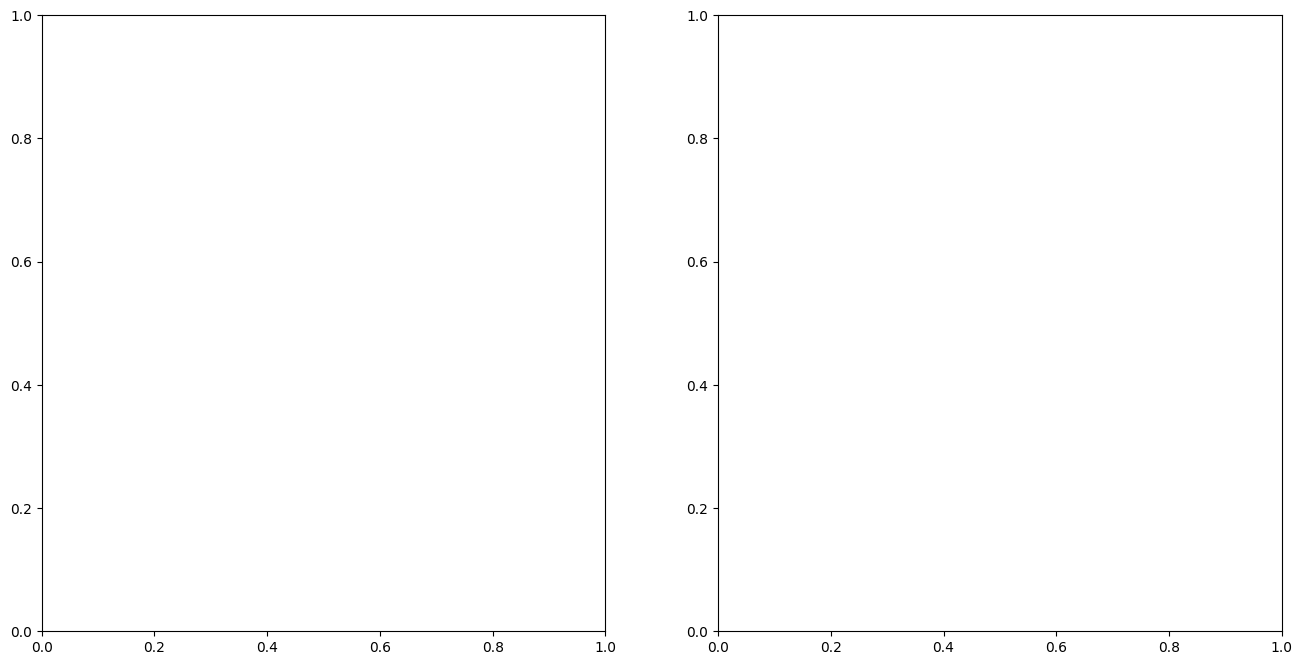

In [6]:
import os
import rasterio
import numpy as np
import torch
import cv2
import gc
from rasterio.windows import Window
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Configuration
MODEL_PATH = "../models/utility_unet.pth"
# Use a different image than training (TIMMOWAL for testing)
INFERENCE_IMAGE_PATH = "../data/images/TIMMOWAL_37695_ORI.tif"
OUTPUT_DIR = "../outputs"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TILE_SIZE = 1024  # Read tiles from disk
INPUT_SIZE = 512  # Model input size (what we trained on)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Load Model
print("Loading model...")
# Reinitialize model architecture
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights=None,  # We'll load trained weights
    in_channels=3,
    classes=1,
)

# Load trained weights
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print(f"✓ Model loaded from {MODEL_PATH}")
else:
    raise FileNotFoundError(f"Model not found at {MODEL_PATH}")

# 2. Inference Function
def predict_utilities(image_path, model, device, tile_size=1024, input_size=512):
    """
    Tile-based inference for utility segmentation
    """
    print(f"Running inference on: {image_path}")
    
    with rasterio.open(image_path) as src:
        height, width = src.height, src.width
        profile = src.profile.copy()
        
        # Full-size output mask
        full_mask = np.zeros((height, width), dtype=np.float32)
        
        print(f"Image size: {width}x{height}")
        
        # Grid
        x_steps = list(range(0, width, tile_size))
        y_steps = list(range(0, height, tile_size))
        total_tiles = len(x_steps) * len(y_steps)
        
        with tqdm(total=total_tiles, desc="Processing tiles") as pbar:
            for row in y_steps:
                for col in x_steps:
                    # Window
                    w_width = min(tile_size, width - col)
                    w_height = min(tile_size, height - row)
                    window = Window(col, row, w_width, w_height)
                    
                    # Read RGB tile
                    img_data = src.read((1, 2, 3), window=window)  # (3, H, W)
                    curr_h, curr_w = img_data.shape[1], img_data.shape[2]
                    
                    # Preprocessing
                    # 1. Transpose to (H, W, C)
                    img_np = img_data.transpose(1, 2, 0)
                    
                    # 2. Resize to model input size (512x512)
                    img_resized = cv2.resize(img_np, (input_size, input_size))
                    
                    # 3. Normalize (ImageNet stats)
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img_norm = (img_resized / 255.0 - mean) / std
                    
                    # 4. To tensor
                    img_t = torch.from_numpy(img_norm.transpose(2, 0, 1)).float().unsqueeze(0).to(device)
                    
                    # Inference
                    with torch.no_grad():
                        with torch.amp.autocast('cuda'):
                            output = model(img_t)
                            # Sigmoid + threshold
                            prob_mask = torch.sigmoid(output).cpu().numpy()[0, 0].astype(np.float32)
                    
                    # Resize back to tile size
                    mask_resized = cv2.resize(prob_mask, (curr_w, curr_h))
                    
                    # Place in full mask
                    full_mask[row:row+curr_h, col:col+curr_w] = mask_resized
                    
                    pbar.update(1)
    
    # Apply threshold
    binary_mask = (full_mask > 0.5).astype(np.uint8)
    
    return binary_mask, profile

# 3. Run Inference
print("\n" + "="*60)
predicted_mask, src_profile = predict_utilities(
    INFERENCE_IMAGE_PATH, model, DEVICE, TILE_SIZE, INPUT_SIZE
)

# 4. Save Binary Mask
mask_output_path = os.path.join(OUTPUT_DIR, "utility_mask.png")
Image.fromarray(predicted_mask * 255).save(mask_output_path)
print(f"✓ Saved mask to: {mask_output_path}")

# 5. Create Overlay (Memory-efficient with downsampling)
print("Creating overlay...")
overlay_output_path = os.path.join(OUTPUT_DIR, "utility_overlay.png")

# Downsample for visualization (prevent RAM crash)
MAX_DIM = 4096
with rasterio.open(INFERENCE_IMAGE_PATH) as src:
    h, w = src.height, src.width
    scale = min(MAX_DIM / w, MAX_DIM / h, 1.0)
    new_w, new_h = int(w * scale), int(h * scale)
    
    print(f"Downsampling overlay to {new_w}x{new_h}")
    
    # Read downsampled image
    image_rgb = src.read(
        (1, 2, 3),
        out_shape=(3, new_h, new_w),
        resampling=rasterio.enums.Resampling.bilinear
    ).transpose(1, 2, 0)

# Downsample mask to match
mask_small = cv2.resize(predicted_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

# Create overlay
overlay = image_rgb.copy()
# Red overlay where utilities detected
overlay[mask_small == 1] = [255, 0, 0]

# Blend
alpha = 0.5
final_overlay = (alpha * image_rgb + (1 - alpha) * overlay).astype(np.uint8)

# Save
Image.fromarray(final_overlay).save(overlay_output_path)
print(f"✓ Saved overlay to: {overlay_output_path}")

# 6. Cleanup
del predicted_mask, image_rgb, overlay, final_overlay, mask_small
gc.collect()
torch.cuda.empty_cache()

print("\n" + "="*60)
print("Inference Complete!")
print("="*60)

# 7. Optional: Display results
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Load saved results
mask_display = Image.open(mask_output_path)
overlay_display = Image.open(overlay_output_path)

axes[0].imshow(mask_display, cmap='gray')
axes[0].set_title("Predicted Utility Mask")
axes[0].axis('off')

axes[1].imshow(overlay_display)
axes[1].set_title("Overlay on Original Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()